<a href="https://colab.research.google.com/github/maheshbabu-r/BIG_DATA_PySpark/blob/main/Reviews__Analysis_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz  # supress download output use -q

!tar -zxvf spark-3.1.2-bin-hadoop3.2.tgz | grep "something" 2>/dev/null #Suppress tar output ---| grep "something" 2>/dev/null--- add after file_name"

!pip -q install findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark import SparkContext

#from pyspark.sql.types import StructType,StructField, StringType, IntegerType

# or import like this
from pyspark.sql.functions import *

from pyspark.sql import functions as F

from pyspark.sql.types import *

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.appName("Analysis Reviews").getOrCreate()
print(spark.sparkContext.appName)

pyspark-shell


In [3]:
!wget -q https://raw.githubusercontent.com/maheshbabu-r/BIG_DATA/main/Hadoop%20Datasets/senticnet4.txt

!wget -q https://github.com/maheshbabu-r/BIG_DATA/blob/main/Hadoop%20Datasets/amazondataset.rar?raw=true

# rename file for better understanding
!mv amazondataset.rar?raw=true amazondataset.rar

!unrar x /content/amazondataset.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/amazondataset.rar

Extracting  amazondataset.csv                                              1%  2%  3%  5%  6%  7%  9% 10% 11% 13% 14% 15% 17% 18% 19% 21% 22% 23% 24% 26% 27% 28% 30% 31% 32% 34% 35% 36% 38% 39% 40% 42% 43% 44% 45% 47% 48% 49% 51% 52% 53% 55% 56% 57% 59% 60% 61% 63% 64% 65% 66% 68% 69% 70% 72% 73% 74% 76% 77% 78% 80% 81% 82% 84% 85% 86% 87% 89% 90% 91% 93% 94% 95% 97% 98% 99%  OK 
All OK


In [4]:
df=spark.read.csv(header=True,inferSchema=True,path="/content/amazondataset.csv")

df.printSchema()

df.show(5)

root
 |-- id: string (nullable = true)
 |-- dateAdded: timestamp (nullable = true)
 |-- dateUpdated: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- asins: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- primaryCategories: string (nullable = true)
 |-- imageURLs: string (nullable = true)
 |-- keys: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- manufacturerNumber: string (nullable = true)
 |-- reviewsdate: string (nullable = true)
 |-- reviewsdateSeen: string (nullable = true)
 |-- reviewsdidPurchase: string (nullable = true)
 |-- reviewsdoRecommend: boolean (nullable = true)
 |-- reviewsid: string (nullable = true)
 |-- reviewsnumHelpful: integer (nullable = true)
 |-- reviewsrating: integer (nullable = true)
 |-- reviewssourceURLs: string (nullable = true)
 |-- reviewstext: string (nullable = true)
 |-- reviewstitle: string (nullable = true)
 |-- reviewsusername: string (nulla

In [5]:
df1=spark.read.option("sep", "\t").csv("/content/senticnet4.txt")

df1.printSchema()

df1.show(3)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)

+---------------+--------+-----+
|            _c0|     _c1|  _c2|
+---------------+--------+-----+
|       32_teeth|positive|0.903|
|       a_little|negative|-0.56|
|a_little_hungry|positive|0.252|
+---------------+--------+-----+
only showing top 3 rows



In [6]:
schema = StructType([ \
    StructField("_c0",StringType(),True), \
    StructField("_c1",StringType(),True),\
    StructField("_c2",FloatType(), True) \
  ])

In [7]:
df1=spark.read.option("sep", "\t").csv("/content/senticnet4.txt",schema=schema)

df1.printSchema()

df1.show(3)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: float (nullable = true)

+---------------+--------+-----+
|            _c0|     _c1|  _c2|
+---------------+--------+-----+
|       32_teeth|positive|0.903|
|       a_little|negative|-0.56|
|a_little_hungry|positive|0.252|
+---------------+--------+-----+
only showing top 3 rows



In [8]:
df1 = df1.withColumnRenamed("_c0","words") \
    .withColumnRenamed("_c1","sentiment") \
    .withColumnRenamed("_c2","value")
df1.printSchema()

root
 |-- words: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- value: float (nullable = true)



In [9]:
df1.show(3)

+---------------+---------+-----+
|          words|sentiment|value|
+---------------+---------+-----+
|       32_teeth| positive|0.903|
|       a_little| negative|-0.56|
|a_little_hungry| positive|0.252|
+---------------+---------+-----+
only showing top 3 rows



In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

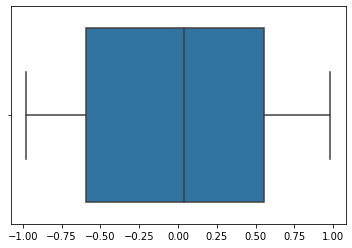

In [11]:
sns.boxplot(x=df1.toPandas()["value"].values.tolist())
plt.show()

In [12]:
x=df1.toPandas()["words"].values.tolist()
y=df1.toPandas()["value"].values.tolist()
ratings=dict(zip(x,y))

In [13]:
def sum_of_list(l):
  total = 0
  for val in l:
    total = total + val
  return total

def reviews_value(reviews):
  y=''.join(e.lower() for e in reviews if (e.isalnum() or e.isspace()))
  y=[x for x in y.split(" ")]
  z=[ratings.get(x) for x in y]
  final=[(0 if x==None else x) for x in z]
  return sum_of_list(final)

In [14]:
texts=df.toPandas()["reviewstext"].values.tolist()
values=[reviews_value(x) for x in texts]

In [15]:
def add_labels(indx):
    return values[indx-1] # since row num begins from 1
labels_udf = udf(add_labels, DoubleType())

In [16]:
df.createOrReplaceTempView('A')
B = spark.sql('select row_number() over(order by "mahesh" ) as num, * from A')

B.show(5)


+---+--------------------+-------------------+-------------------+--------------------+--------------------+------------+--------------------+-----------------+--------------------+--------------------+------------+------------------+--------------------+--------------------+------------------+------------------+---------+-----------------+-------------+--------------------+--------------------+--------------------+----------------+--------------------+
|num|                  id|          dateAdded|        dateUpdated|                name|               asins|       brand|          categories|primaryCategories|           imageURLs|                keys|manufacturer|manufacturerNumber|         reviewsdate|     reviewsdateSeen|reviewsdidPurchase|reviewsdoRecommend|reviewsid|reviewsnumHelpful|reviewsrating|   reviewssourceURLs|         reviewstext|        reviewstitle| reviewsusername|          sourceURLs|
+---+--------------------+-------------------+-------------------+------------------

In [17]:
new_df = B.withColumn('Rating', labels_udf('num'))
new_df.show()

+---+--------------------+-------------------+-------------------+--------------------+--------------------+------------+--------------------+-----------------+--------------------+--------------------+------------+------------------+--------------------+--------------------+------------------+------------------+---------+-----------------+-------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+
|num|                  id|          dateAdded|        dateUpdated|                name|               asins|       brand|          categories|primaryCategories|           imageURLs|                keys|manufacturer|manufacturerNumber|         reviewsdate|     reviewsdateSeen|reviewsdidPurchase|reviewsdoRecommend|reviewsid|reviewsnumHelpful|reviewsrating|   reviewssourceURLs|         reviewstext|        reviewstitle|   reviewsusername|          sourceURLs|              Rating|
+---+--------------------+------------

In [18]:
texts

['I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.',
 'Bulk is always the less expensive way to go for products like these',
 'Well they are not Duracell but for the price i am happy.',
 'Seem to work as well as name brand batteries at a much better price',
 'These batteries are very long lasting the price is great.',
 "Bought a lot of batteries for Christmas and the AmazonBasics Cell have been good. I haven't noticed a difference between the brand name batteries and the Amazon Basic brand. Just a lot easier to purchase and have arrive at the house and have on hand. Will buy again.",
 'ive not had any problame with these batteries have ordered them in the past been very pleased.',
 'Well if you are looking for cheap non-rechargeable batteries that last quite a while then these are perfect. Nothing more to say.',
 'These do not hold the amount of high power juice like energizer or duracell, but th

In [19]:
values

[1.2419999577105045,
 -1.1450000517070293,
 1.6849999725818634,
 0.8079999685287476,
 -0.25299999490380287,
 5.510999962687492,
 1.1090000160038471,
 2.564999971538782,
 2.3639999981969595,
 4.752999972552061,
 -0.17799996584653854,
 0.7600000128149986,
 1.391999937593937,
 3.3849999830126762,
 1.4119999967515469,
 4.616999983787537,
 1.260999996215105,
 3.006000006571412,
 1.474999986588955,
 0.17200005240738392,
 -0.42700003273785114,
 -0.9279999975115061,
 -1.2449999824166298,
 -0.2579999938607216,
 1.218000065535307,
 1.5379999801516533,
 1.5400000251829624,
 3.2419999428093433,
 3.9709999412298203,
 0.23600006476044655,
 -0.4760000426322222,
 2.0310000348836184,
 2.54899993725121,
 0.20299996435642242,
 3.323999986052513,
 2.296999990940094,
 3.6929999701678753,
 1.3049999214708805,
 0.9419999867677689,
 3.6479999758303165,
 -0.2699999772012234,
 0.13500000163912773,
 1.9419999793171883,
 3.304999988526106,
 0.4829999804496765,
 0.3450000397861004,
 1.1360000185668468,
 0.75900002